In [247]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd
import librosa
import librosa.display
import os
from os import path
import io
!pip3 install soundfile
!pip3 install librosa
import soundfile as sf
import librosa.feature


time: 6.86 s


In [2]:
!pip install ipython-autotime

%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=9f8a69a350abc9c93c0527e75dafa0aeaacef4c4cda68ba7a820c37e3a276ee2
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


# Opening datasets

In [3]:
DIR = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class' 
DIR_AUDIO = DIR + '/soundfiles/TAU-urban-acoustic-scenes-2020-3class-development/'
df_meta = pd.read_csv(f'{DIR}/meta.csv')
df_meta = pd.read_csv(io.StringIO(df_meta.to_csv(index=False)))
df_meta.head()

,filename,scene_label,identifier
0,audio/airport-barcelona-0-0-a.wav,indoor,barcelona-0
1,audio/airport-barcelona-0-10-a.wav,indoor,barcelona-0
2,audio/airport-barcelona-0-11-a.wav,indoor,barcelona-0
3,audio/airport-barcelona-0-12-a.wav,indoor,barcelona-0
4,audio/airport-barcelona-0-13-a.wav,indoor,barcelona-0


time: 3.64 s


# Getting part of the dataset
Não coloquei 10% dele, pois poderiam vir mais datasets de um label específico. E nem coloquei 10% de cada label, pois a quantidades de datasets dentro de cada label é diferente. Então defini n datasets de cada label.

In [397]:
df = df_meta.groupby('scene_label', as_index=False).apply(lambda x: x.sample(n=500, random_state=15))
df.index = [i[1] for i in df.index]
df.head()

,filename,scene_label,identifier
3028,audio/metro_station-helsinki-231-6952-a.wav,indoor,helsinki-231
9493,audio/shopping_mall-milan-1183-45376-a.wav,indoor,milan-1183
4163,audio/metro_station-stockholm-85-2308-a.wav,indoor,stockholm-85
3224,audio/metro_station-lisbon-1020-42471-a.wav,indoor,lisbon-1020
9294,audio/shopping_mall-lyon-1066-42583-a.wav,indoor,lyon-1066


time: 28.5 ms


In [398]:
# so neste caso q n vamos usar transportation
df = df.loc[df['scene_label'] != 'transportation']

time: 3.25 ms


In [399]:
print(df.loc[df['scene_label'] == 'outdoor'].shape)
print(df.loc[df['scene_label'] == 'indoor'].shape)
print(df.loc[df['scene_label'] == 'transportation'].shape)

(500, 3)
(500, 3)
(0, 3)
time: 4.47 ms


Reading the datasets and storing it to 'signals'

In [400]:
info_sound = df[['filename','scene_label']].to_numpy()
LABELS = ['indoor', 'outdoor']

time: 2.84 ms


In [401]:
dic_signals = {x:[] for i, x in enumerate(LABELS)}

for filename, label in info_sound:
    if(path.isfile(os.path.join(DIR_AUDIO, filename))):
        dic_signals[label].append(sf.read(os.path.join(DIR_AUDIO, filename)))

time: 7min 23s


Labels:


0.   Indoor
1.   Outdoor
2.   Transportation



# Getting Features

1.   Centroid Mean
2.   Centroid STD
3.   Flatness Mean
4.   Flatness STD
5.   RMS



In [402]:
PARTS = 10
def get_features(dic_signals)->pd.DataFrame:
    # LUANA - FEATURES
    def get_centroid(S, sr):
        return librosa.feature.spectral_centroid(S=S, sr=sr)
    def get_flatness(S):
        return librosa.feature.spectral_flatness(S=S)
    def get_rms(S):
        return librosa.feature.rms(S=S)
    def get_mfccs(S, sr):
        return librosa.feature.mfcc(S=S, sr=sr)

    feats = (np.zeros((1,8))[0])
    
    j = 1
    k = 0 #label
    for label, signals in dic_signals.items():
        for signal, samplerate in signals:
            music_features = []
            signal = signal[:,0]
            #print(len(signal))
            mel = librosa.feature.melspectrogram(y=signal,sr=samplerate, hop_length=512)
            mel = np.asarray(mel)
            #print(mel.shape)
            i = 1
            for banda in np.array_split(mel, 16):
                #print(banda.shape)
                for second in np.array_split(banda, 10, axis=1):
                    #print(np.array(second).shape)
                    c = get_centroid(second, samplerate)
                    f = get_flatness(second)
                    r = get_rms(second)
                    MUSIC_FEATURES = np.array([np.mean(c),np.std(c),np.mean(f), np.std(f), r[0][0],k, i, j])
                    feats = np.vstack([feats, MUSIC_FEATURES])
                i += 1
            j += 1
        k += 1
        df = pd.DataFrame(data=feats).drop(0).reset_index(drop=True)
        df = df.rename(columns={0: "C-M", 1: "C-STD", 2:'F-M', 3:'F-STD',4: 'RMS', 5: 'LABEL', 6: 'BANDA', 7:'MUSIC_ID'})
    return df
        


time: 27.7 ms


In [403]:
df = get_features(dic_signals)

time: 3min 57s


In [404]:
df.to_csv("/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/features.csv")

time: 1.9 s


In [405]:
df = pd.read_csv("/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/features.csv").drop("Unnamed: 0",axis=1) 

time: 238 ms


In [406]:
df

,C-M,C-STD,F-M,F-STD,RMS,LABEL,BANDA,MUSIC_ID
0,3998.155298,2042.803022,0.051401,7.592399e-02,1.455866e-02,0.0,1.0,1.0
1,4614.764699,1881.893539,0.082918,8.887290e-02,3.392321e-02,0.0,1.0,1.0
2,4448.222099,1961.603718,0.068439,8.782371e-02,5.273105e-03,0.0,1.0,1.0
3,4929.042084,1444.453232,0.071201,5.902405e-02,6.072835e-02,0.0,1.0,1.0
4,5605.334431,2141.432445,0.111589,1.053903e-01,7.928555e-03,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...
148475,8985.685746,3251.709240,1.000000,2.220446e-16,1.139410e-08,1.0,16.0,928.0
148476,9467.198430,2912.806430,1.000000,2.220446e-16,2.766249e-08,1.0,16.0,928.0
148477,8881.491767,1125.439340,1.000000,2.220446e-16,4.169076e-08,1.0,16.0,928.0
148478,9099.379075,1595.039531,1.000000,2.220446e-16,2.969168e-07,1.0,16.0,928.0


time: 29 ms


In [407]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import pickle
from collections import Counter
from sklearn.decomposition import PCA
import seaborn as sns

time: 2.78 ms


Split no dataframe baseado em grupos do número da música

In [408]:
def split_by_music_id(df):
    train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 2).split(df, groups=df['MUSIC_ID']))
    return [train_inds, test_inds]

time: 1.92 ms


Split no dataframe selecionado, em teste e treino

In [409]:
def split_train_test(df,train_inds, test_inds):
    X_train = (df.iloc[train_inds, 0:-3])
    X_test = (df.iloc[test_inds,0:-3])
    y_train = (df.iloc[train_inds,[5,6,7]]).values
    y_test = (df.iloc[test_inds,[5,6,7]]).values
    return [X_train, X_test, y_train, y_test]

time: 3.11 ms


In [410]:
def standardize(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train.values)
    X_train = scaler.transform(X_train.values)
    X_test = scaler.transform(X_test.values)
    return [X_train, X_test]

time: 2.24 ms


# Building a KNN Model

In [411]:
def get_knn_model(X_train,X_test, y_train, y_test):

    def get_k_accuracy(X_train, X_test, y_train, y_test): 
        def knn_classifier(k, X_train, X_test, y_train, y_test):
            #print(y_train)
            knn = KNeighborsClassifier(n_neighbors = k)
            knn.fit(X_train,y_train)
            y_pred = knn.predict(X_test)
            #print(y_pred)
            return metrics.accuracy_score(y_test,y_pred)

        def plot_scores(x,y):
            fig, a = plt.subplots(1, figsize = (10, 8))
            title = "Accuracy Score by K values"
            plt.title(title)
            plt.xlabel('Value of K for KNN')
            plt.ylabel('Testing Accuracy')
            a.plot(x, y)

        k_range = range(1,15)
        scores = {}
        scores_list = []

        for k in k_range:
            scores[k] = knn_classifier(k, X_train, X_test, y_train, y_test)
            scores_list.append(scores[k])

        #plot_scores(list(k_range), scores_list)
        #print('Accuracy Sem Votação: ' + str(scores[max(scores, key= scores.get)]))
        return max(scores, key= scores.get)

    k = get_k_accuracy(X_train,X_test, y_train[:,0], y_test[:,0])
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train[:,0])
    saved_model = pickle.dumps(knn)
    return saved_model

time: 21.9 ms


Contagem das predições para cada música

In [412]:
def contagem_predicoes(y_test, y_pred):
    counts = dict()
    for id in np.unique(y_test[:,2]):
        counts[id] = []
    #print(counts)
    for t, p in zip(y_test, y_pred):
        counts[t[2]].append(p)
    counter = [Counter(y) for x,y in counts.items()]
    return counter

def acc_votacao(counter, y_test):
    #print(np.unique(y_test[1]))
    #print(counter, y_test)
    music_y_pred = [max(x, key=x.get) for x in counter]
    #print(music_y_pred)
    music_y_test = [[x,z] for x,y,z in y_test]
    music_y_test = np.unique(music_y_test, axis=0)[:,0]
    return metrics.accuracy_score(music_y_test,music_y_pred)

time: 8.02 ms


In [418]:
def pca(X_test, y_test):
    pca = PCA(3)
    trans_pca = pca.fit_transform(X_test)
    trans_pca = pd.DataFrame(trans_pca)
    trans_pca['Labels'] = y_test[:,0]
    trans_pca["Labels"] = ["$%s$" % x for x in trans_pca["Labels"]]
    print(pca.explained_variance_)
    trans_pca.columns = ['PC1', 'PC2','PC3','Labels']
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=trans_pca['PC1'], y=trans_pca['PC2'], hue=trans_pca['Labels'])

time: 6.15 ms


Dividindo o dataframe por banda. 
Temos 16 bandas + 1 banda com o dataframe todo.

In [414]:
collection = []
for banda in range(1,17):
    collection.append(df.loc[df['BANDA'] == banda])

collection.append(df)

time: 24.5 ms


In [415]:
def plot_accs_bandas(x,y):
    fig, a = plt.subplots(1, figsize = (10, 8))
    title = "Accuracy Score by Band values"
    plt.title(title)
    plt.xlabel('Valor de Cada Banda')
    plt.ylabel('Testing Accuracy')
    a.plot(x, y, 'o-')
    plt.xticks(x)
    plt.show()

time: 3.83 ms


In [419]:
def classify(collection):
    final_accs = []
    for df in collection:
        train_inds, test_inds = split_by_music_id(df)
        X_train, X_test, y_train, y_test = split_train_test(df,train_inds, test_inds)
        X_train, X_test = standardize(X_train, X_test)
        saved_model = get_knn_model(X_train,X_test, y_train, y_test)
        knn = pickle.loads(saved_model) 
        y_pred = knn.predict(X_test) 
        contagens = contagem_predicoes(y_test, y_pred)
        #print(contagens)
        final_accuracy = acc_votacao(contagens, y_test)
        #print('Accuracy Com Votação: ' + str(final_accuracy))
        final_accs.append(final_accuracy)
    plot_accs_bandas(list(range(1,18)),final_accs)
    pca(X_test, y_test)
    return np.array(final_accs)

time: 8.38 ms


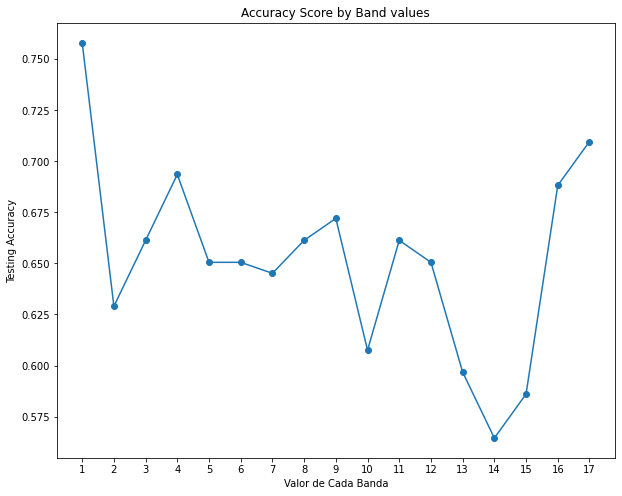

[2.29592187 1.08144583 0.39302705]


0.7567567567567568

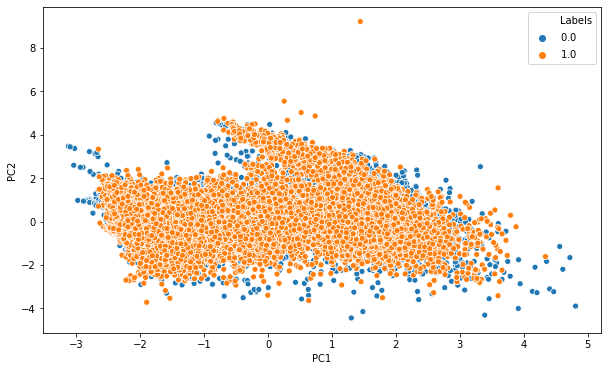

time: 47.5 s


In [423]:
final_accs = classify(collection)
np.max(final_accuracy)